# VAE Model Testing Framework

# Hyperparemeters

In [1]:
import torch

#### deterministic run ####
deterministic_run = True
seed = 0
mode = 'seed_only'

##### Model parameters #####
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
model_decoder_output_dist = 'gaussian'  # Output distribution of the decoder (e.g., 'bernoulli', 'gaussian')
latent_dim = 10

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 5

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'betavae'      # Type of loss ('betavae', 'annealedvae', 'betatcvae')
loss_kwargs = {
    'beta': 16,
    'rec_dist': 'gaussian',  # Reconstruction distribution ('bernoulli', 'gaussian')
    'log_kl_components':True
               }

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

Using GPU


# Reproducibility

In [2]:
if deterministic_run: 
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(seed=seed, mode=mode)
    print(f"Set deterministic run with seed {seed} and mode \"{mode}\"")

Set deterministic run with seed 0 and mode "seed_only"


## 1. Imports

In [3]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## 3. Load Datasets

### Shapes 3d

In [4]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

if deterministic_run:
    shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=seed,
                                                   pin_memory=True)
else:
    shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_3dshapes, 
                                                      shuffle=True, 
                                                      pin_memory=True)


print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")


Loaded 3D Shapes dataset with 480000 samples.


### dSprites

In [5]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if deterministic_run:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## 4. Setup Model, Loss, and Optimizer

In [6]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Model
    model = vae_models.select(name=model_name, img_size=img_size, latent_dim=latent_dim)

    if loss_name == 'betatcvae':
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.__class__.__name__}")
    print(f"Loss: {loss_fn.__class__.__name__} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## 5. Train and Visualize

## 5.1 - 3D Shapes

In [7]:
shapes3d_loss_kwargs = loss_kwargs.copy()
shapes3d_loss_kwargs.update({'beta': 16})

In [8]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)


model_3dshapes = torch.compile(
    model_3dshapes,
    backend="inductor",      # fastest on CUDA/ROCm & most maintained
    mode="max-autotune",     # lets Inductor search more kernel variants
    # fullgraph=True,          # refuse graph‑breaks so everything is fused
    # dynamic=False,           # assume static shapes – avoids run‑time guards
)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss_fn=loss_fn_3dshapes,
                                      lr_scheduler=None,
                                      optimizer=optimizer_3dshapes,
                                      device=device,
                                      train_step_unit=train_step_unit,
                                      )

trainer_3dshapes.train(shapes3d_dataloader, max_steps=num_train_steps)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: Model
Loss: Loss (rec_dist=gaussian), kwargs={'beta': 16, 'rec_dist': 'gaussian', 'log_kl_components': True}
Optimizer: Adam
---------------------------


Epoch 1:   0%|          | 0/7500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
[2025-05-06 10:36:43,779] [0/0] torch._inductor.utils: [WARNING] not enough SMs to use max_autotune_gemm mode


### Visualization

In [9]:
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

#### Reconstructions

Plotting random reconstructions...


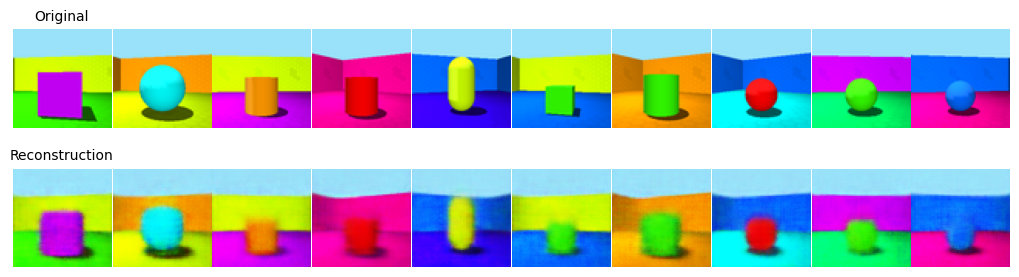

Plotting reconstructions from specific indices...


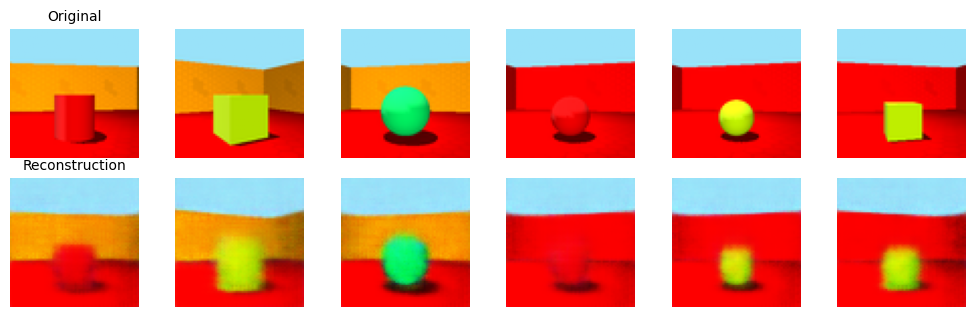

In [10]:
print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

#### Latent traversal

Plotting latent traversals...


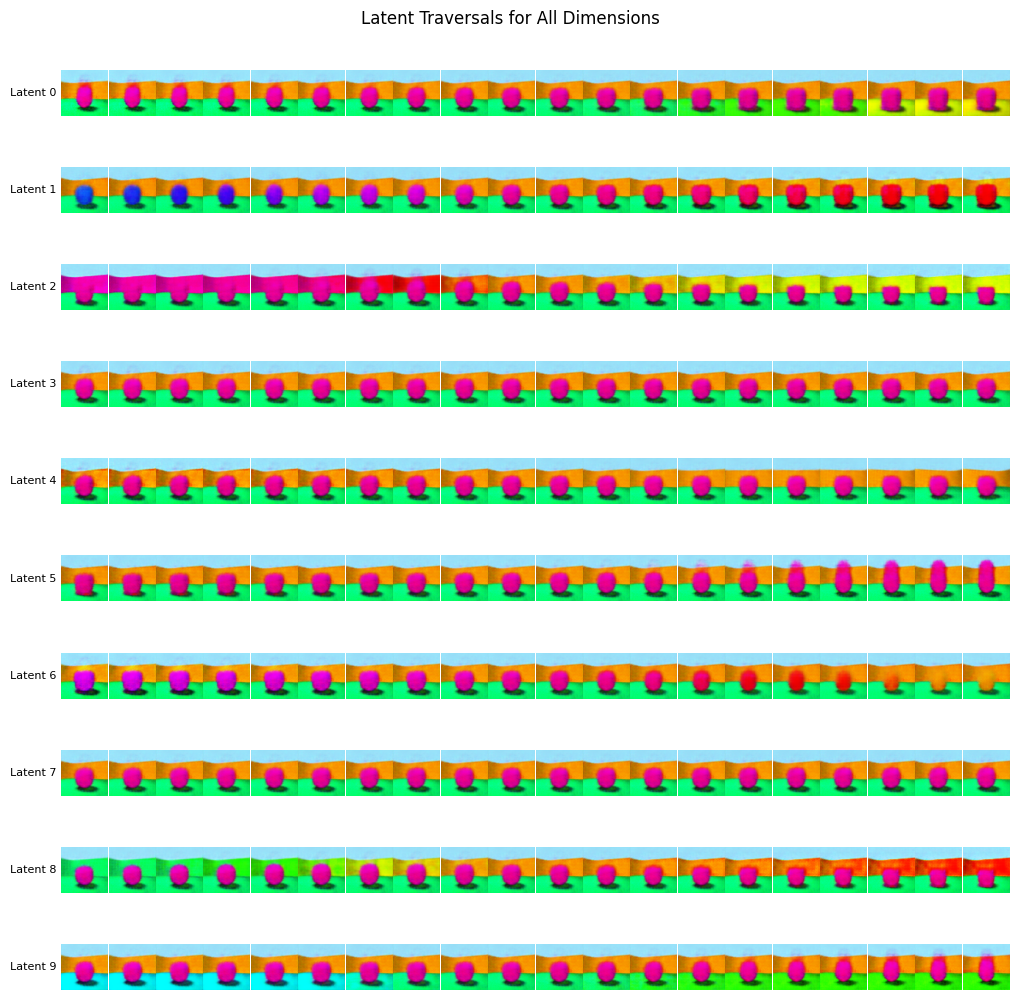

In [25]:
print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

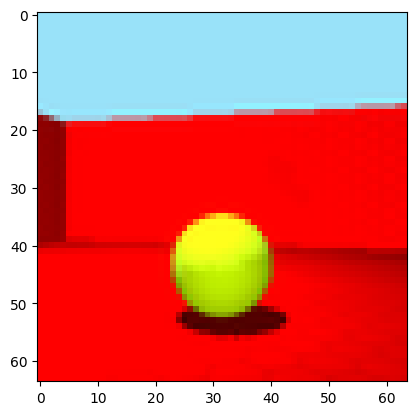

In [30]:
ref_img_idx = 1000
ref_img = shapes3d_dataset[ref_img_idx][0]
plt.imshow(ref_img.permute(1, 2, 0).cpu().numpy())

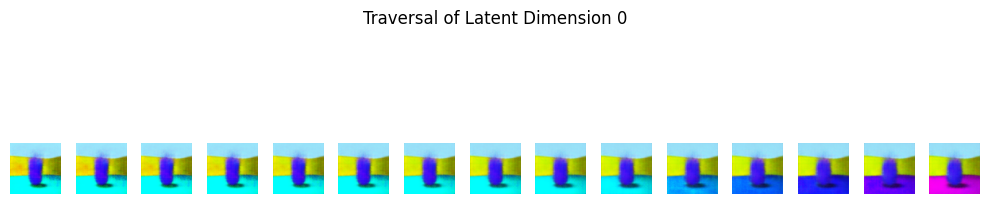

In [33]:
# single latent traversal based on the reference image
latent_idx = 0  # Index of the latent dimension to traverse
visualizer_3dshapes.plot_single_latent_traversal(latent_idx, 
                                                 ref_img=None, 
                                                 num_samples=15,
                                                 max_traversal_type='absolute', 
                                                 max_traversal=2)

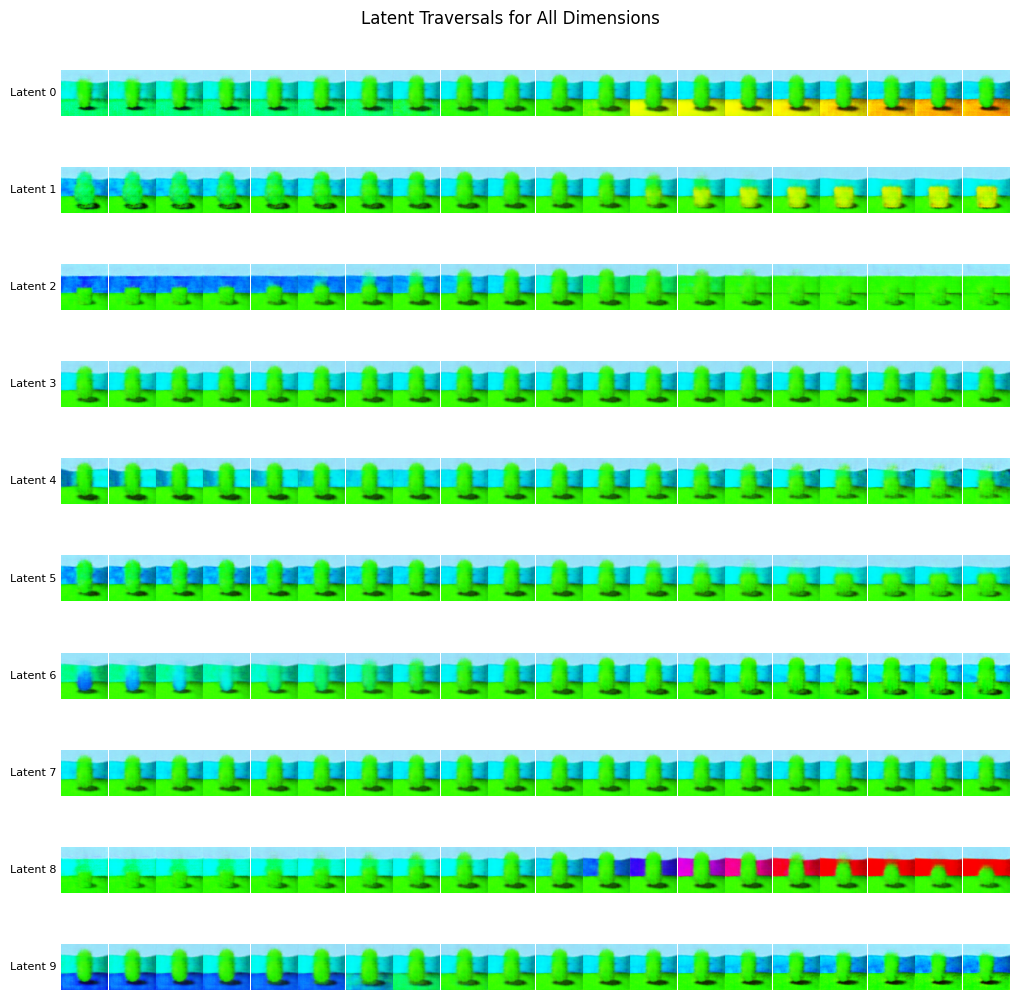

In [35]:
visualizer_3dshapes.plot_all_latent_traversals(ref_img=None, 
                                               num_samples=20, 
                                               max_traversal=3, 
                                               max_traversal_type='absolute')

### 5.1.1 Metric Evaluation (3D Shapes)

In [22]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}}, # Added num_train and num_test
    {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
]

metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:25<00:00, 299.29it/s]


3D Shapes Metrics: {'dci_d': {'informativeness_train_errors': 0.06156666666666666, 'informativeness_test_errors': 0.18899999999999997, 'informativeness_train_scores': 0.9384333333333332, 'informativeness_test_scores': 0.811, 'disentanglement': 0.5124263505327458, 'completeness': 0.4914340251786325}, 'mig': 0.2639106016852993}


## 5.2. Train and Visualize: dSprites

### Loss args

In [ ]:
# Beta VAE
loss_kwargs_beta_vae_dsprites =  {
    'beta': 4,
    'rec_dist': model_decoder_output_dist, # Use the globally defined rec_dist
    'log_kl_components':True
               }

In [18]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_beta_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                     loss_fn=loss_fn_dsprites,
                                     lr_scheduler=None,
                                     optimizer=optimizer_dsprites,
                                     device=device,
                                     train_step_unit=train_step_unit,
                                     )

trainer_dsprites.train(dsprites_dataloader, max_steps=num_train_steps)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'beta': 4, 'rec_dist': 'bernoulli'}
Optimizer: Adam
---------------------------



===== Visualizing dSprites Results =====
Plotting random reconstructions...


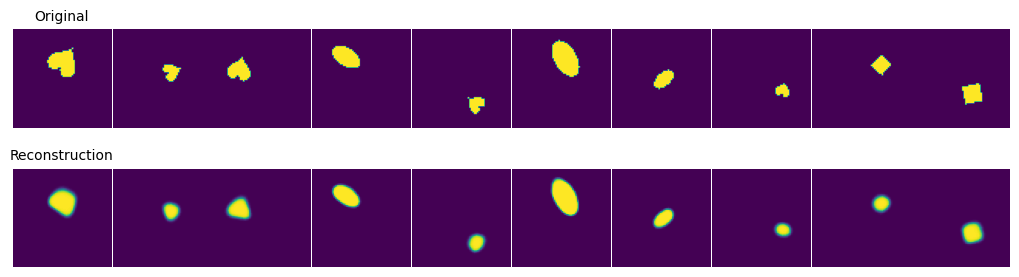

Plotting reconstructions from specific indices...


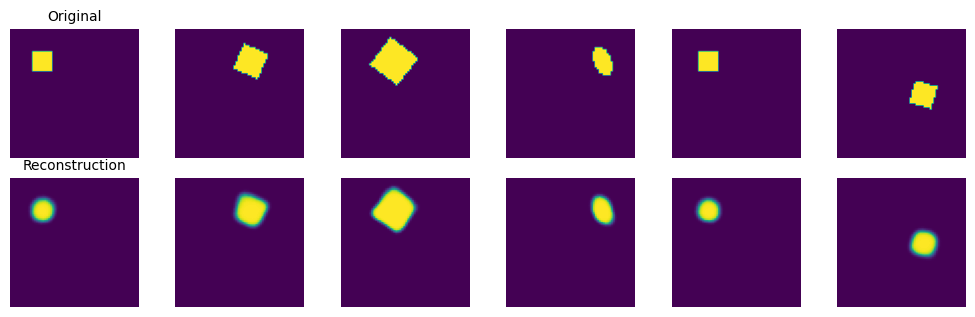

Plotting latent traversals...


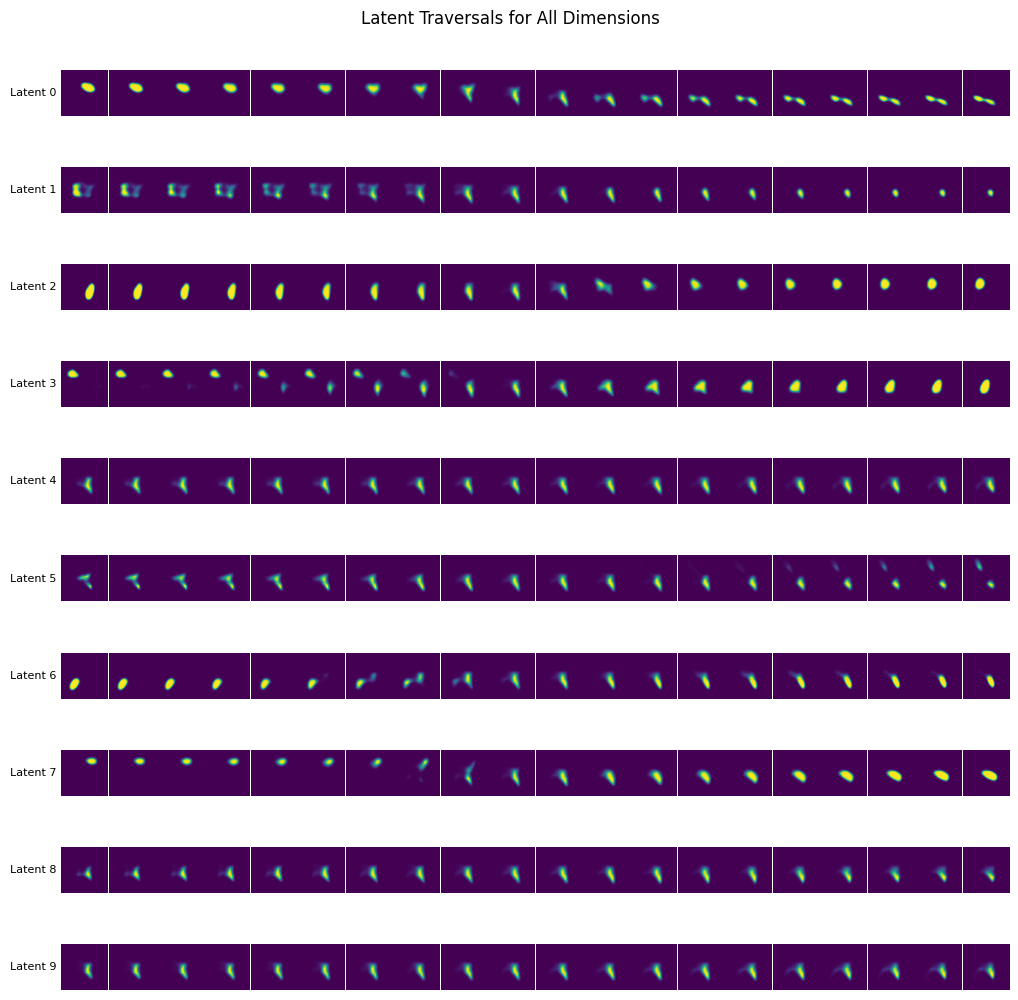

In [ ]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)

#### Reconstructions

In [ ]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

#### Latent traversal

In [ ]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

In [ ]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 10000  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

# Single latent traversal based on the reference image
latent_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_idx_dsprites, ref_img=ref_img_dsprites, num_samples=10)
plt.show()

# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, num_samples=20)
plt.show()

### 5.2.1 Metric Evaluation (dSprites)

In [ ]:
print("\n===== Computing Metrics for dSprites =====")
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)